In [1]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

In [2]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [3]:
cursor = db_connection.cursor()

In [4]:
dfs = pd.read_sql("SELECT * FROM spoonacular", db_connection)

### 16. Anteil vegane/vegetarische/fleischhaltige Gerichte

In [5]:
dfs_wod = dfs.drop_duplicates(subset=["url"])
parts = dfs_wod[["vegetarian", "vegan"]].sum()
fges = dfs_wod["vegetarian"].count()
fvegn = dfs_wod["vegan"].sum()
fvegt = dfs_wod["vegetarian"].sum() - fvegn
frest = fges - fvegt - fvegn

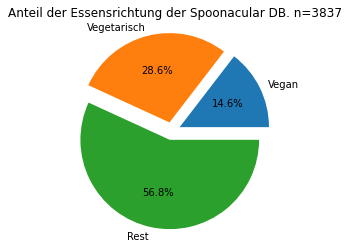

In [6]:
plt.pie([fvegn, fvegt, frest], 
        labels=["Vegan", "Vegetarisch", "Rest"],
       autopct='%1.1f%%', explode=(0.1,0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Essensrichtung der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 17. Anteil laktosefreie Gerichte

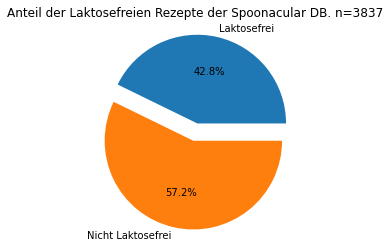

In [7]:
plt.pie([dfs_wod["dairy_free"].sum(), 
         dfs_wod["dairy_free"].count() - dfs_wod["dairy_free"].sum()], 
        labels=["Laktosefrei", "Nicht Laktosefrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Laktosefreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 18. Anteil glutenfreier Gerichte

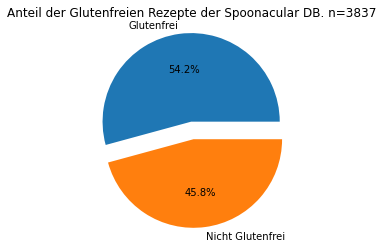

In [8]:
plt.pie([dfs_wod["gluten_free"].sum(), 
         dfs_wod["gluten_free"].count() - dfs_wod["gluten_free"].sum()], 
        labels=["Glutenfrei", "Nicht Glutenfrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Glutenfreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["gluten_free"].count()))
plt.show()

### 19. Bewertung im Verhältnis zu Inhaltsstoffen

#### a) Zucker

In [9]:
dfs_wod.insert(loc=0, column="likes/sugar", value=(dfs_wod["likes"]/dfs_wod["sugar"]))

#### b) Fett

In [10]:
dfs_wod.insert(loc=0, column="likes/fat", value=(dfs_wod["likes"]/dfs_wod["fat"]))

#### c) Kalorien

In [11]:
dfs_wod.insert(loc=0, column="likes/calories", value=(dfs_wod["likes"]/dfs_wod["calories"]))

In [12]:
dfs_filtered = dfs_wod[(dfs_wod["likes/sugar"] < dfs_wod["likes/sugar"].quantile(0.9))]

In [14]:
dfs_filtered.describe()

,likes/calories,likes/fat,likes/sugar,id,vegetarian,vegan,gluten_free,dairy_free,likes,ready_in_minutes,calories,sugar,fat
count,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000
mean,0.011436,inf,0.272885,3985.322908,0.419635,0.129453,0.536345,0.410368,3.533160,48.576021,377.479583,19.345207,12.571098
std,0.020750,NaN,0.422114,2385.589446,0.493571,0.335749,0.498750,0.491972,8.713767,38.628828,227.281451,15.575504,13.472600
min,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,10.000000,1.000000,0.000000
25%,0.002347,0.076923,0.047619,2307.000000,0.000000,0.000000,0.000000,0.000000,1.000000,45.000000,202.000000,8.000000,4.000000
50%,0.004386,0.181818,0.100000,4166.000000,0.000000,0.000000,1.000000,0.000000,1.000000,45.000000,340.000000,15.000000,8.000000
75%,0.010204,0.500000,0.285714,5992.000000,1.000000,0.000000,1.000000,1.000000,2.000000,45.000000,513.000000,27.000000,16.000000
max,0.198391,inf,2.642857,7789.000000,1.000000,1.000000,1.000000,1.000000,146.000000,660.000000,1682.000000,115.000000,87.000000


Text(0.5, 1.0, 'Likes')

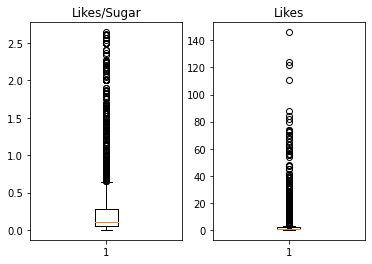

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(dfs_filtered["likes/sugar"])
ax1.set_title("Likes/Sugar")
ax2.boxplot(dfs_filtered["likes"])
ax2.set_title("Likes")

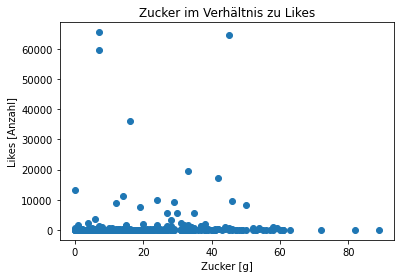

In [17]:
dfs_filtered = dfs_wod[(dfs_wod["likes"] > dfs_wod["likes"].quantile(0.9))]
plt.scatter(dfs_filtered["sugar"], dfs_filtered["likes"])
plt.xlabel("Zucker [g]")
plt.ylabel("Likes [Anzahl]")
plt.title("Zucker im Verhältnis zu Likes")
plt.show()

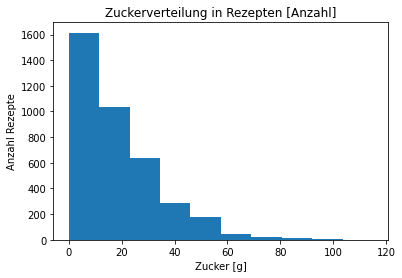

In [20]:
plt.hist(dfs_wod["sugar"])
plt.title("Zuckerverteilung in Rezepten [Anzahl]")
plt.xlabel("Zucker [g]")
plt.ylabel("Anzahl Rezepte")
plt.show()

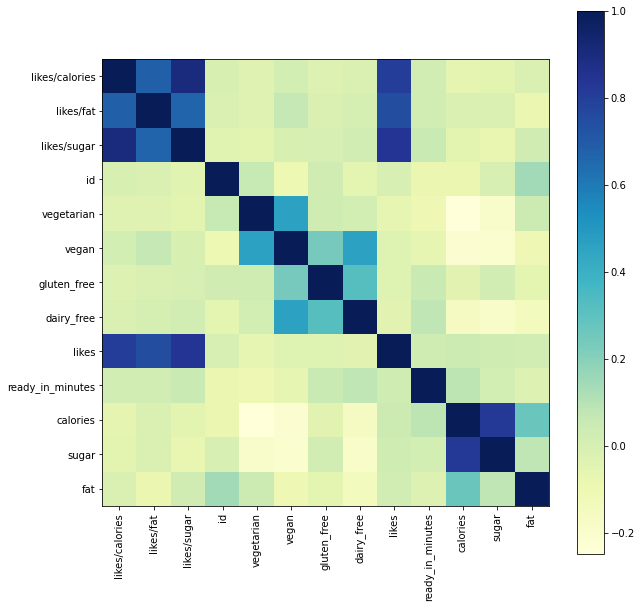

In [36]:
x = dfs_filtered.corr()
# fig, ax = plt.subplots(1, 1, figsize=(15,5))
# ax.imshow(x, cmap="YlGnBu")

plt.figure(figsize=(10,10))
plt.imshow(x, cmap="YlGnBu")
plt.colorbar()


plt.xticks(range(len(x)),x.columns, rotation=90)

plt.yticks(range(len(x)),x.columns)
plt.show()
# fig.show()

In [ ]:
dfs_fil

Aufgrund der Korrelationstabelle lässt sich ableiten, dass sich kein Zusammenhang zwischen Zutaten und Likes sowie der Zubereitungszeit und den Likes erkennen

In [ ]:
p_dairy_free = dfs_wod["dairy_free"].sum()/dfs_wod["dairy_free"].count()
p_vegan = dfs_wod["vegan"].sum()/dfs_wod["vegan"].count()
p_vegan_and_dairy_free = dfs_wod[(dfs_wod["dairy_free"]==1) & (dfs_wod["vegan"]==1)]["vegan"].sum()/dfs_wod["dairy_free"].count()


In [ ]:
p_a_b = p_vegan_and_dairy_free/p_dairy_free

p_b_a = p_vegan_and_dairy_free/p_vegan

In [ ]:
print(f"P(A|B) = {p_a_b} und P(B|A) = {p_b_a}")

In [ ]:
dfs_wod.describe()

In [ ]:
dfs_wod[(dfs_wod["vegan"] == 1) & (dfs_wod["dairy_free"] == 1)].describe()

In [ ]:
dfs_wod[dfs_wod["likes"]>50000]